In [449]:
import sys
sys.path.append('/mnt/disk05/note/workspaces/duxx')
from feature_selector import FeatureSelector
from unity import init_pkg as ini
from unity.eda_func import EdaFunc as edf
from unity.fea_eda_func import FeaEdaFunc as fef
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,roc_curve
import os
import json
import datetime
import gc
import scorecardpy as sc
from imblearn.over_sampling import SMOTE
import math
# import pickle
# import joblib
# import pandas_profiling

% matplotlib inline

In [450]:
e1 = ini.pd.read_csv(open('data/bd/百度7月180天表现.csv'))
e2 = ini.pd.read_csv(open('data/bd/百度8月150天表现.csv'))
ext_bdtag = ini.pd.concat([e1,e2])

In [451]:
ext_bdbank = ini.pd.read_pickle('data/bd/ext_bdbank.pkl')
ext_bdbank=ext_bdbank[ext_bdbank['TRANSACTION_TYPE']=='apply']
ext_bdtag['tag'] = 0
ext_bdtag.loc[ext_bdtag['ovdue_days']>30,'tag'] = 1
ext_bdtag = ext_bdtag.groupby('cert_no')['tag'].max().reset_index(name='tag')
ext_bdbank = ext_bdbank.sort_values('CREATED_DATE',ascending=0).drop_duplicates('ID_CARD_NO',keep='last')
ext_bdbank = ext_bdbank.dropna(subset=['ID','ID_CARD_NO'])
ext_bdbank = ext_bdbank.rename({'ID_CARD_NO':'cert_no'},axis=1)
ext_bdmain = ext_bdbank.merge(ext_bdtag,on='cert_no')
del ext_bdbank,ext_bdtag

In [452]:
# 加入伪标签
bdmain = ini.pd.read_csv('data/bd/merge_with_fake.csv') 

In [453]:
# 读取LR分箱
def zxCreditCardRcyDelqDate_bin(v):
    if v==-9999:
        return 0
    elif v<=711:
        return 1
    else:
        return 2
    
def zxCreditCardRcyUpdateDate_bin(v):
    if v==-9999:
        return 0
    elif v<=803:
        return 1
    else:
        return 2
    
def zxLoanRcyDelqDate_bin(v):
    if v==-9999:
        return 0
    elif v<=436:
        return 1
    else:
        return 2

def zxFirstLoanMonth_bin(v):
    if v==-9999:
        return 0
    elif v<=46:
        return 1
    elif v<=78:
        return 2
    else:
        return 3

def zxFirstCreCardDate_bin(v):
    v_M = math.ceil(v/30)
    if v_M==-333:
        return 0
    elif v_M<=163:
        return 1
    else:
        return 2
    
def zxHouseFundPayLastMonth_bin(v):
    if v==-9999:
        return 0
    elif v<=34:
        return 1
    else:
        return 2
    
def zxHouseFundRecordUpdate_bin(v):
    if v==-9999:
        return 0
    elif v<=2841:
        return 1
    else:
        return 2
    
def zxLoanRcyUpdateDate_bin(v):
    if v==-9999:
        return 0
    elif v<=245:
        return 1
    elif v<=268:
        return 2
    elif v<=323:
        return 3
    elif v<=472:
        return 4
    else:
        return 5
    
def zxAccountCnt_bin(v):
    if v==-9999:
        return 0
    elif v<=10:
        return 1
    else:
        return 2

def zxRcy1MLoanQueryCnt_bin(v):
    if v==0:
        return 0
    elif v<=4:
        return 1
    else:
        return 2

def zxRcy1MLoanQueryCompanyCnt_bin(v):
    if v==0:
        return 0
    elif v<=4:
        return 1
    else:
        return 2
    
def zxRcy6MLoanQueryCnt_bin(v):
    if v<=5:
        return 0
    elif v<=10:
        return 1
    else:
        return 2
    
def zxRcy6MLoanQueryCompanyCnt_bin(v):
    if v<=4:
        return 0
    elif v<=8:
        return 1
    else:
        return 2

def zxRcy3MLoanQueryCnt_bin(v):
    if v<=2:
        return 0
    elif v<=4:
        return 1
    else:
        return 2
    
def zxRcy3MLoanQueryCompanyCnt_bin(v):
    if v<=2:
        return 0
    elif v<=4:
        return 1
    else:
        return 2
    
def zxIssuBankCnt_bin(v):
    if v==-9999:
        return 0
    elif v==1:
        return 1
    else:
        return 2
    
def zxCreCardMaxMonthsCnt_bin(v):
    if v==-9999:
        return 0
    else:
        return 1

def zxCreCardDelqAccoutCnt_bin(v):
    if v==-9999:
        return 0
    else:
        return 1
    
def zxCreditCardAccuDelqCnt_bin(v):
    if v==-9999:
        return 0
    elif v==0:
        return 1
    else:
        return 2
    
def zxLoanBalCnt_bin(v):
    if v==-9999:
        return 0
    elif v<=2:
        return 1
    elif v<=4:
        return 2
    else:
        return 3
    
def zxLoanCompanyBalCnt_bin(v):
    if v==-9999:
        return 0
    elif v<=3:
        return 1
    elif v<=7:
        return 2
    else:
        return 3
    
def zxRcy12MCreCardMaxDelqPeriod_bin(v):
    if v==-9999:
        return 0
    else:
        return 1

def zxRcy24MCreCardMaxDelqPeriod_bin(v):
    if v==-9999:
        return 0
    else:
        return 1
def zxHouseFundCompanyRate_bin(v):
    if v==0:
        return 0
    else:
        return 1
    
def zxHouseFundSelfRate_bin(v):
    if v==0:
        return 0
    else:
        return 1
    
def zxCreCardUseCreditRate_bin(v):
    if v==-9999:
        return 0
    elif v<=0.53:
        return 1
    else:
        return 2
    
def zxTotalCreditAmt_bin(v):
    if v==-9999:
        return 0
    elif v==0:
        return 0
    else:
        return 1
    
def zxUseCreditAmt_bin(v):
    if v==-9999:
        return 0
    elif v==0:
        return 0
    elif v<=131000:
        return 1
    else:
        return 2
    
def zxCreditBal_bin(v):
    if v==-9999:
        return 0
    elif v==0:
        return 0
    elif v<=131000:
        return 1
    else:
        return 2
    
def zxRcy6MAvgUseCreditAmt_bin(v):
    if v==-9999:
        return 0
    elif v==0:
        return 0
    else:
        return 1
    
def zxCreditAvgLimit_bin(v):
    if v==-9999:
        return 0
    elif v==0:
        return 0
    elif v<=14000:
        return 1
    else:
        return 2
    
def zxMaxCreditAmt_bin(v):
    if v==-9999:
        return 0
    elif v==0:
        return 0
    else:
        return 1
    
def zxMinCreditAmt_bin(v):
    if v==-9999:
        return 0
    elif v==0:
        return 0
    else:
        return 1
    
def zxBlanceShouldPayAmt_bin(v):# 非单调
    if v<=1000:
        return 0
    elif v<=5000:
        return 1
    else:
        return 2
    
def zxCreCardNowShouldPayAmt_bin(v):
    if v==0:
        return 0
    elif v==-9999:
        return 0
    elif v<=7800:
        return 1
    else:
        return 2

def zxHouseLoan1MAvgPayAmt_bin(v):
    if v==-9999:
        return 0
    elif v==0:
        return 0
    elif v<=4600:
        return 1
    else:
        return 2
    
def zxRcy6MAvgPayAmt_bin(v):
    if v<=2800:
        return 0
    elif v<=6800:
        return 1
    else:
        return 2
    
def zxHouseFundMonthPayAmt_bin(v):
    if v<=0:
        return 0
    elif v<=700:
        return 1
    else:
        return 2
    
def zxCreCardDelqMaxAmt_bin(v):
    if v<=0:
        return 0
    elif v<=7000:
        return 1
    else:
        return 2

# def zxHouseFundMonthShouldPayAmt_bin(v):

def zxRcy6MCreCardMaxDelqPeriod_bin(v):
    if v==-9999:
        return 0
    else:
        return 1
    
def zxLoanBalanceAmt_bin(v):
    if v<=130000:
        return 0
    elif v<=1309000:
        return 1
    else:
        return 2

In [454]:
date_feas = list(ext_bdmain.loc[:,ext_bdmain.columns.str.contains('Date|LastMonth|DATE|FirstLoan|Update')].columns)
ext_bdmain['zxHouseFundPayLastMonth'] = ext_bdmain['zxHouseFundPayLastMonth'].replace('0002-12',ini.np.nan)
ext_bdmain.loc[:,date_feas] = ext_bdmain[date_feas].replace([-9999,'-9999'],ini.np.nan)
ext_bdmain.loc[:,date_feas] = ext_bdmain[date_feas].astype('datetime64[ns]')
date_feas.remove('CREATED_DATE')
for c in date_feas:
    ext_bdmain[c] = abs((ext_bdmain['CREATED_DATE'] - ext_bdmain[c]).dt.days)
ext_bdmain.loc[:,date_feas] = ext_bdmain[date_feas].fillna(0)

In [455]:
# bdmain=bdmain.drop(['ovdue_days','unionLoanUsed' 'idpicture0' 'photowithidcard' 'orderId' 'livingPhoto'],axis=1)

In [456]:
ext_bdmain['zxCreditCardRcyDelqDate_bin'] = ext_bdmain['zxCreditCardRcyDelqDate'].map(zxCreditCardRcyDelqDate_bin)
ext_bdmain['zxCreditCardRcyUpdateDate_bin'] = ext_bdmain['zxCreditCardRcyUpdateDate'].map(zxCreditCardRcyUpdateDate_bin)
ext_bdmain['zxLoanRcyDelqDate_bin'] = ext_bdmain['zxLoanRcyDelqDate'].map(zxLoanRcyDelqDate_bin)
ext_bdmain['zxFirstLoanMonth_bin'] = ext_bdmain['zxFirstLoanMonth'].map(zxFirstLoanMonth_bin)
ext_bdmain['zxFirstCreCardDate_bin'] = ext_bdmain['zxFirstCreCardDate'].map(zxFirstCreCardDate_bin)
ext_bdmain['zxHouseFundPayLastMonth_bin'] = ext_bdmain['zxHouseFundPayLastMonth'].map(zxHouseFundPayLastMonth_bin)
ext_bdmain['zxHouseFundRecordUpdate_bin'] = ext_bdmain['zxHouseFundRecordUpdate'].map(zxHouseFundRecordUpdate_bin)
ext_bdmain['zxLoanRcyUpdateDate_bin'] = ext_bdmain['zxLoanRcyUpdateDate'].map(zxLoanRcyUpdateDate_bin)

In [457]:
ext_bdmain.loc[:,ext_bdmain.columns.str.contains('Cnt')] = ext_bdmain.loc[:,ext_bdmain.columns.str.contains('Cnt')].astype(float)

In [458]:
ext_bdmain['zxAccountCnt_bin'] = ext_bdmain['zxAccountCnt'].map(zxAccountCnt_bin)
ext_bdmain['zxRcy1MLoanQueryCnt_bin'] = ext_bdmain['zxRcy1MLoanQueryCnt'].map(zxRcy1MLoanQueryCnt_bin)
ext_bdmain['zxRcy1MLoanQueryCompanyCnt_bin'] = ext_bdmain['zxRcy1MLoanQueryCompanyCnt'].map(zxRcy1MLoanQueryCompanyCnt_bin)
ext_bdmain['zxRcy6MLoanQueryCnt_bin'] = ext_bdmain['zxRcy6MLoanQueryCnt'].map(zxRcy6MLoanQueryCnt_bin)
ext_bdmain['zxRcy6MLoanQueryCompanyCnt_bin'] = ext_bdmain['zxRcy6MLoanQueryCompanyCnt'].map(zxRcy6MLoanQueryCompanyCnt_bin)
ext_bdmain['zxRcy3MLoanQueryCnt_bin'] = ext_bdmain['zxRcy3MLoanQueryCnt'].map(zxRcy3MLoanQueryCnt_bin)
ext_bdmain['zxRcy3MLoanQueryCompanyCnt_bin'] = ext_bdmain['zxRcy3MLoanQueryCompanyCnt'].map(zxRcy3MLoanQueryCompanyCnt_bin)
ext_bdmain['zxIssuBankCnt_bin'] = ext_bdmain['zxIssuBankCnt'].map(zxIssuBankCnt_bin)
ext_bdmain['zxCreCardMaxMonthsCnt_bin'] = ext_bdmain['zxCreCardMaxMonthsCnt'].map(zxCreCardMaxMonthsCnt_bin)
ext_bdmain['zxCreCardDelqAccoutCnt_bin'] = ext_bdmain['zxCreCardDelqAccoutCnt'].map(zxCreCardDelqAccoutCnt_bin)
ext_bdmain['zxCreditCardAccuDelqCnt_bin'] = ext_bdmain['zxCreditCardAccuDelqCnt'].map(zxCreditCardAccuDelqCnt_bin)
ext_bdmain['zxLoanBalCnt_bin'] = ext_bdmain['zxLoanBalCnt'].map(zxLoanBalCnt_bin)
ext_bdmain['zxLoanCompanyBalCnt_bin'] = ext_bdmain['zxLoanCompanyBalCnt'].map(zxLoanCompanyBalCnt_bin)
ext_bdmain['zxRcy12MCreCardMaxDelqPeriod_bin'] = ext_bdmain['zxRcy12MCreCardMaxDelqPeriod'].map(zxRcy12MCreCardMaxDelqPeriod_bin)
ext_bdmain['zxRcy24MCreCardMaxDelqPeriod_bin'] = ext_bdmain['zxRcy24MCreCardMaxDelqPeriod'].map(zxRcy24MCreCardMaxDelqPeriod_bin)
ext_bdmain['zxRcy6MCreCardMaxDelqPeriod_bin'] = ext_bdmain['zxRcy6MCreCardMaxDelqPeriod'].map(zxRcy6MCreCardMaxDelqPeriod_bin)

In [459]:
ext_bdmain.loc[:,ext_bdmain.columns.str.contains('Amt|Bal|AvgLimit')] = ext_bdmain.loc[:,ext_bdmain.columns.str.contains('Amt|Bal|AvgLimit')].astype(float)

In [460]:
ext_bdmain['zxHouseFundCompanyRate'] = ext_bdmain['zxHouseFundCompanyRate'].str.extract('(\d+)').astype(float).replace(9999,0)
ext_bdmain['zxHouseFundSelfRate'] = ext_bdmain['zxHouseFundSelfRate'].str.extract('(\d+)').astype(float).replace(9999,0)
ext_bdmain['zxCreCardUseCreditRate'] = ext_bdmain['zxCreCardUseCreditRate'].astype(float).replace(-9999,0)

In [461]:
ext_bdmain['zxHouseFundCompanyRate_bin'] = ext_bdmain['zxHouseFundCompanyRate'].map(zxHouseFundCompanyRate_bin)
ext_bdmain['zxHouseFundSelfRate_bin'] = ext_bdmain['zxHouseFundSelfRate'].map(zxHouseFundSelfRate_bin)
ext_bdmain['zxCreCardUseCreditRate_bin'] = ext_bdmain['zxCreCardUseCreditRate'].map(zxCreCardUseCreditRate_bin)
ext_bdmain['zxTotalCreditAmt_bin'] = ext_bdmain['zxTotalCreditAmt'].map(zxTotalCreditAmt_bin)
ext_bdmain['zxUseCreditAmt_bin'] = ext_bdmain['zxUseCreditAmt'].map(zxUseCreditAmt_bin)
ext_bdmain['zxCreditBal_bin'] = ext_bdmain['zxCreditBal'].map(zxCreditBal_bin)
ext_bdmain['zxRcy6MAvgUseCreditAmt_bin'] = ext_bdmain['zxRcy6MAvgUseCreditAmt'].map(zxRcy6MAvgUseCreditAmt_bin)
ext_bdmain['zxCreditAvgLimit_bin'] = ext_bdmain['zxCreditAvgLimit'].map(zxCreditAvgLimit_bin)
ext_bdmain['zxMaxCreditAmt_bin'] = ext_bdmain['zxMaxCreditAmt'].map(zxMaxCreditAmt_bin)
ext_bdmain['zxMinCreditAmt_bin'] = ext_bdmain['zxMinCreditAmt'].map(zxMinCreditAmt_bin)
ext_bdmain['zxBlanceShouldPayAmt_bin'] = ext_bdmain['zxBlanceShouldPayAmt'].map(zxBlanceShouldPayAmt_bin)
ext_bdmain['zxCreCardNowShouldPayAmt_bin'] = ext_bdmain['zxCreCardNowShouldPayAmt'].map(zxCreCardNowShouldPayAmt_bin)
ext_bdmain['zxHouseLoan1MAvgPayAmt_bin'] = ext_bdmain['zxHouseLoan1MAvgPayAmt'].map(zxHouseLoan1MAvgPayAmt_bin)
ext_bdmain['zxRcy6MAvgPayAmt_bin'] = ext_bdmain['zxRcy6MAvgPayAmt'].map(zxRcy6MAvgPayAmt_bin)
ext_bdmain['zxHouseFundMonthPayAmt_bin'] = ext_bdmain['zxHouseFundMonthPayAmt'].map(zxHouseFundMonthPayAmt_bin)
ext_bdmain['zxCreCardDelqMaxAmt_bin'] = ext_bdmain['zxCreCardDelqMaxAmt'].map(zxCreCardDelqMaxAmt_bin)
ext_bdmain['zxLoanBalanceAmt_bin'] = ext_bdmain['zxLoanBalanceAmt'].map(zxLoanBalanceAmt_bin)

In [462]:
# bdmain 分箱
bdmain['zxCreditCardRcyDelqDate_bin'] = bdmain['zxCreditCardRcyDelqDate'].map(zxCreditCardRcyDelqDate_bin)
bdmain['zxCreditCardRcyUpdateDate_bin'] = bdmain['zxCreditCardRcyUpdateDate'].map(zxCreditCardRcyUpdateDate_bin)
bdmain['zxLoanRcyDelqDate_bin'] = bdmain['zxLoanRcyDelqDate'].map(zxLoanRcyDelqDate_bin)
bdmain['zxFirstLoanMonth_bin'] = bdmain['zxFirstLoanMonth'].map(zxFirstLoanMonth_bin)
bdmain['zxFirstCreCardDate_bin'] = bdmain['zxFirstCreCardDate'].map(zxFirstCreCardDate_bin)
bdmain['zxHouseFundPayLastMonth_bin'] = bdmain['zxHouseFundPayLastMonth'].map(zxHouseFundPayLastMonth_bin)
bdmain['zxHouseFundRecordUpdate_bin'] = bdmain['zxHouseFundRecordUpdate'].map(zxHouseFundRecordUpdate_bin)
bdmain['zxLoanRcyUpdateDate_bin'] = bdmain['zxLoanRcyUpdateDate'].map(zxLoanRcyUpdateDate_bin)

In [463]:
bdmain['zxAccountCnt_bin'] = bdmain['zxAccountCnt'].map(zxAccountCnt_bin)
bdmain['zxRcy1MLoanQueryCnt_bin'] = bdmain['zxRcy1MLoanQueryCnt'].map(zxRcy1MLoanQueryCnt_bin)
bdmain['zxRcy1MLoanQueryCompanyCnt_bin'] = bdmain['zxRcy1MLoanQueryCompanyCnt'].map(zxRcy1MLoanQueryCompanyCnt_bin)
bdmain['zxRcy6MLoanQueryCnt_bin'] = bdmain['zxRcy6MLoanQueryCnt'].map(zxRcy6MLoanQueryCnt_bin)
bdmain['zxRcy6MLoanQueryCompanyCnt_bin'] = bdmain['zxRcy6MLoanQueryCompanyCnt'].map(zxRcy6MLoanQueryCompanyCnt_bin)
bdmain['zxRcy3MLoanQueryCnt_bin'] = bdmain['zxRcy3MLoanQueryCnt'].map(zxRcy3MLoanQueryCnt_bin)
bdmain['zxRcy3MLoanQueryCompanyCnt_bin'] = bdmain['zxRcy3MLoanQueryCompanyCnt'].map(zxRcy3MLoanQueryCompanyCnt_bin)
bdmain['zxIssuBankCnt_bin'] = bdmain['zxIssuBankCnt'].map(zxIssuBankCnt_bin)
bdmain['zxCreCardMaxMonthsCnt_bin'] = bdmain['zxCreCardMaxMonthsCnt'].map(zxCreCardMaxMonthsCnt_bin)
bdmain['zxCreCardDelqAccoutCnt_bin'] = bdmain['zxCreCardDelqAccoutCnt'].map(zxCreCardDelqAccoutCnt_bin)
bdmain['zxCreditCardAccuDelqCnt_bin'] = bdmain['zxCreditCardAccuDelqCnt'].map(zxCreditCardAccuDelqCnt_bin)
bdmain['zxLoanBalCnt_bin'] = bdmain['zxLoanBalCnt'].map(zxLoanBalCnt_bin)
bdmain['zxLoanCompanyBalCnt_bin'] = bdmain['zxLoanCompanyBalCnt'].map(zxLoanCompanyBalCnt_bin)
bdmain['zxRcy12MCreCardMaxDelqPeriod_bin'] = bdmain['zxRcy12MCreCardMaxDelqPeriod'].map(zxRcy12MCreCardMaxDelqPeriod_bin)
bdmain['zxRcy24MCreCardMaxDelqPeriod_bin'] = bdmain['zxRcy24MCreCardMaxDelqPeriod'].map(zxRcy24MCreCardMaxDelqPeriod_bin)
bdmain['zxRcy6MCreCardMaxDelqPeriod_bin'] = bdmain['zxRcy6MCreCardMaxDelqPeriod'].map(zxRcy6MCreCardMaxDelqPeriod_bin)

In [464]:
bdmain['zxCreCardUseCreditRate'] = bdmain['zxCreCardUseCreditRate'].astype(float).replace(-9999,0)

In [465]:
bdmain['zxHouseFundCompanyRate_bin'] = bdmain['zxHouseFundCompanyRate'].map(zxHouseFundCompanyRate_bin)
bdmain['zxHouseFundSelfRate_bin'] = bdmain['zxHouseFundSelfRate'].map(zxHouseFundSelfRate_bin)
bdmain['zxCreCardUseCreditRate_bin'] = bdmain['zxCreCardUseCreditRate'].map(zxCreCardUseCreditRate_bin)
bdmain['zxTotalCreditAmt_bin'] = bdmain['zxTotalCreditAmt'].map(zxTotalCreditAmt_bin)
bdmain['zxUseCreditAmt_bin'] = bdmain['zxUseCreditAmt'].map(zxUseCreditAmt_bin)
bdmain['zxCreditBal_bin'] = bdmain['zxCreditBal'].map(zxCreditBal_bin)
bdmain['zxRcy6MAvgUseCreditAmt_bin'] = bdmain['zxRcy6MAvgUseCreditAmt'].map(zxRcy6MAvgUseCreditAmt_bin)
bdmain['zxCreditAvgLimit_bin'] = bdmain['zxCreditAvgLimit'].map(zxCreditAvgLimit_bin)
bdmain['zxMaxCreditAmt_bin'] = bdmain['zxMaxCreditAmt'].map(zxMaxCreditAmt_bin)
bdmain['zxMinCreditAmt_bin'] = bdmain['zxMinCreditAmt'].map(zxMinCreditAmt_bin)
bdmain['zxBlanceShouldPayAmt_bin'] = bdmain['zxBlanceShouldPayAmt'].map(zxBlanceShouldPayAmt_bin)
bdmain['zxCreCardNowShouldPayAmt_bin'] = bdmain['zxCreCardNowShouldPayAmt'].map(zxCreCardNowShouldPayAmt_bin)
bdmain['zxHouseLoan1MAvgPayAmt_bin'] = bdmain['zxHouseLoan1MAvgPayAmt'].map(zxHouseLoan1MAvgPayAmt_bin)
bdmain['zxRcy6MAvgPayAmt_bin'] = bdmain['zxRcy6MAvgPayAmt'].map(zxRcy6MAvgPayAmt_bin)
bdmain['zxHouseFundMonthPayAmt_bin'] = bdmain['zxHouseFundMonthPayAmt'].map(zxHouseFundMonthPayAmt_bin)
bdmain['zxCreCardDelqMaxAmt_bin'] = bdmain['zxCreCardDelqMaxAmt'].map(zxCreCardDelqMaxAmt_bin)
bdmain['zxLoanBalanceAmt_bin'] = bdmain['zxLoanBalanceAmt'].map(zxLoanBalanceAmt_bin)

In [466]:
def bin_group_single(df, col, target):
    """
    单个特征iv,woe
    """
    regroup = df.groupby([col])['tag'].agg(['count','sum']).replace(0,0.0001)\
                .rename({'sum':'bad'},axis=1)\
                .assign(variable=col,
                        count_distr = lambda x:x['count']/sum(x['count']),
                        good=lambda x:x['count']-x['bad'],
                        badprob = lambda x:x['bad']/x['count'],
                        DistrBad = lambda x:x['good']/sum(x['good']),
                        DistrGood = lambda x:x['bad']/sum(x['bad']),
                        woe = lambda x:ini.np.log(x['DistrBad']/x['DistrGood']),
                        bin_iv = lambda x:(x['DistrBad']-x['DistrGood'])*x['woe'],
                        total_iv = lambda x:sum(x.bin_iv))
    regroup.reset_index(level=0,inplace=True)
    return regroup

def bin_group(df, cols, target,missing=True):
    """
    """
    dfc = df.copy()
    bin_df_dicts = {}
    if missing: dfc.loc[:,cols] = dfc.fillna('missing')
    for c in cols:
        bin_df = bin_group_single(dfc,c,target)
        bin_df_dicts[c] = bin_df
    return bin_df_dicts

def badrate_ply(df,cols, bin_df_dicts,missing=True):
    """
    badrate编码转化
    """
    if missing: df.loc[:,cols] = df.fillna('missing')
    bin_badp_dicts = {c:dict(zip(bin_df_dicts[c][c],bin_df_dicts[c]['badprob'])) for c in cols}
    df.replace(bin_badp_dicts,inplace=True)
    return df

def calc_psi(train_bin_dicts,test_bin_dicts):
    """
    根据分箱后的结果计算PSI
    test_bin_dicts 为woe后的结果
    """
    psi_dict = {}
    for k,te in test_bin_dicts.items():
        if 'woe' in k:
            k = k.split('_woe')[0]
            te = te.rename({'%s_woe' % k:k},axis=1).set_index(k)
            tr = train_bin_dicts[k].rename({'woe':k},axis=1).set_index(k)
        else:
            te = te.set_index(k)
            tr = train_bin_dicts[k].set_index(k)
        pair = ini.pd.concat([te['count_distr'],tr['count_distr']],axis=1,keys=['test','train'])
        psi = sum(((pair['test']-pair['train'])*(ini.np.log(pair['test']/pair['train']))).dropna())
        psi_dict[k] = psi
    return psi_dict

In [467]:
bdmain = bdmain.loc[:,bdmain.columns.str.contains('_bin|tag')]

In [468]:
ext_bdmain07 = ext_bdmain.loc[(ext_bdmain['CREATED_DATE'].dt.month==7),ext_bdmain.columns.str.contains('_bin|tag')]
ext_bdmain08 = ext_bdmain.loc[(ext_bdmain['CREATED_DATE'].dt.month==8),ext_bdmain.columns.str.contains('_bin|tag')]
ext_bdmain0708 = ext_bdmain.loc[:,ext_bdmain.columns.str.contains('_bin|tag')]

In [469]:
train_bin_dicts = bin_group(bdmain,bdmain.drop('tag',axis=1).columns,'tag')

In [470]:
test_bin_dicts07 = bin_group(ext_bdmain07,ext_bdmain07.drop('tag',axis=1).columns,'tag')
test_bin_dicts08 = bin_group(ext_bdmain08,ext_bdmain08.drop('tag',axis=1).columns,'tag')
test_bin_dicts0708 = bin_group(ext_bdmain0708,ext_bdmain0708.drop('tag',axis=1).columns,'tag')

In [471]:
psi0708 = calc_psi(train_bin_dicts,test_bin_dicts0708)
psi07 = calc_psi(train_bin_dicts,test_bin_dicts07)
psi08 = calc_psi(train_bin_dicts,test_bin_dicts08)

In [472]:
# psi_dict = {}
# for k,te in test_bin_dicts0708.items():
#     if 'woe' in k:
#         k = k.split('_woe')[0]
#         te = te.rename({'%s_woe' % k:k},axis=1).set_index(k)
#         tr = train_bin_dicts[k].rename({'woe':k},axis=1).set_index(k)
#     else:
#         te = te.set_index(k)
#         tr = train_bin_dicts[k].set_index(k)
#     pair = ini.pd.concat([te['count_distr'],tr['count_distr']],axis=1,keys=['test','train'])
#     psi = sum(((pair['test']-pair['train'])*(ini.np.log(pair['test']/pair['train']))).dropna())
#     psi_dict[k] = psi
#     break

In [473]:
train_bin_dicts['zxFirstLoanMonth_bin']

,zxFirstLoanMonth_bin,count,bad,variable,count_distr,good,badprob,DistrBad,DistrGood,woe,bin_iv,total_iv
0,1,399,3.0,zxFirstLoanMonth_bin,0.010586,396.0,0.007519,0.010661,0.005484,0.664693,0.003441,0.020294
1,2,1055,6.0,zxFirstLoanMonth_bin,0.027991,1049.0,0.005687,0.028241,0.010969,0.945724,0.016335,0.020294
2,3,36237,538.0,zxFirstLoanMonth_bin,0.961423,35699.0,0.014847,0.961097,0.983547,-0.023089,0.000518,0.020294


In [474]:
test_bin_dicts0708['zxFirstLoanMonth_bin']

,zxFirstLoanMonth_bin,count,bad,variable,count_distr,good,badprob,DistrBad,DistrGood,woe,bin_iv,total_iv
0,1,132,1.0000,zxFirstLoanMonth_bin,0.002813,131.0000,0.007576,0.002821,2.061855e-03,0.313473,0.000238,0.005439
1,2,30,0.0001,zxFirstLoanMonth_bin,0.000639,29.9999,0.000003,0.000646,2.061855e-07,8.049810,0.005199,0.005439
2,3,46761,484.0000,zxFirstLoanMonth_bin,0.996548,46277.0000,0.010351,0.996533,9.979379e-01,-0.001409,0.000002,0.005439


In [475]:
ini.pd.concat([ini.pd.DataFrame(psi07,index=['psi']).T.sort_values('psi'),ini.pd.DataFrame(psi08,index=['psi']).T.sort_values('psi')],axis=1,
              keys=['07','08'])

,07,08
,psi,psi
zxAccountCnt_bin,0.008976,0.017883
zxBlanceShouldPayAmt_bin,0.020082,0.020299
zxCreCardDelqAccoutCnt_bin,0.021900,0.000883
zxCreCardDelqMaxAmt_bin,0.025165,0.001581
zxCreCardMaxMonthsCnt_bin,0.021900,0.000883
zxCreCardNowShouldPayAmt_bin,0.029512,0.008859
zxCreCardUseCreditRate_bin,0.059268,0.039115
zxCreditAvgLimit_bin,0.006429,0.107400
zxCreditBal_bin,0.018013,0.014307


In [476]:
lr = LogisticRegression()
lr.fit(bdmain.drop('tag',axis=1),bdmain['tag'])

LogisticRegression()

In [477]:
pred_y07 = lr.predict_proba(ext_bdmain07.drop('tag',axis=1))[:,1]
pred_y08 = lr.predict_proba(ext_bdmain08.drop('tag',axis=1))[:,1]

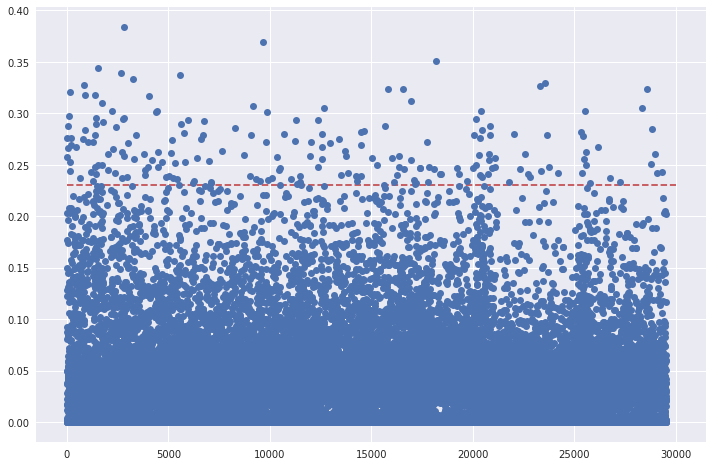

In [90]:
ini.plt.figure(figsize=(12,8))
ini.plt.plot(pred_y07,'o')
ini.plt.hlines(0.23,0,30000,color='r',linestyle='--')

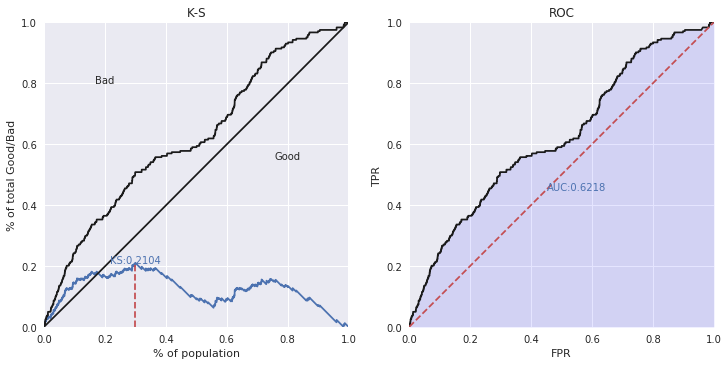

{'AUC': 0.6218,
 'Gini': 0.2436,
 'KS': 0.2104,
 'pic': <Figure size 864x432 with 2 Axes>}

In [89]:
sc.perf_eva(ext_bdmain07['tag'],pred_y07)

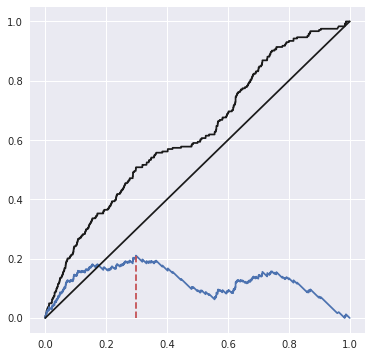

In [160]:
# KS简化版
fpr,tpr,threshold = roc_curve(ext_bdmain07['tag'],pred_y07)
ini.plt.figure(figsize=(6,6))
ks_array = tpr-fpr
ks_index = fpr[ks_array==max(ks_array)]
ini.plt.plot(fpr,tpr,'k-')
ini.plt.plot(fpr,tpr-fpr,'b-')
ini.plt.plot([0,1],'k-')h 
ini.plt.plot([ks_index,ks_index],[0,max(tpr-fpr)],'r--')

In [427]:
ext_bdmain07.to_csv('data/bd/oot_bdmain07.csv',index=False)
ext_bdmain08.to_csv('data/bd/oot_bdmain08.csv',index=False)

In [426]:
# 导出PSI
ini.pd.concat([ini.pd.DataFrame(psi07,index=['psi']).T.sort_values('psi'),ini.pd.DataFrame(psi08,index=['psi']).T.sort_values('psi')],axis=1,
              keys=['07','08']).to_excel('07_08_psi.xlsx')